## Calculate non-dimensional numbers for Barkley Canyon fitted profiles (Pathways Cruise)

Scaling the advection-diffusion equation gives the following non dimensional parameters:


| Symbol | Definition | Description | Barkley Canyon estimate |
|:------:|:----------:|:-------------:|:-----------------------:|
|$Pe_h$  | $\frac{LU*}{ \kappa_{I}}$| Horizontal Peclet number | $2.11 \times 10^2 $ |      
|$Pe_v$  | $\frac{Z \Omega}{ \kappa_{D}}$ | Vertical Peclet number | $1.24$ |       
| $K$    | $\frac{Z^2}{L^2}\frac{\kappa_{I}}{\kappa_{D}}$ | Diffusivity ratio |$5.88 \times 10^{-3} $ |
|$\Gamma$| $\frac{Z}{L} \frac{\delta_{v}C}{\delta_{h}C} $ | Gradient ratio | Tracer dependent |
|$\tau_h$|$\frac{ L \delta^2_{h}C}{\Gamma  \delta_{h}C}$  |Horizontal torsion to curvature ratio | Tracer dependent |
|$\tau_v$|$-\frac{Z \delta^2_{v}C}{ \delta_{v}C}$ | Vertical torsion to curvature ratio | Tracer dependent |

In this notebook I calculate the 'tracer dependent values' using data from the Pathways cruise.

*I still need to add DIC and TA data

In this notebook I got:

 $K=5.907\times10^{-3}$, $Pe_v=1.227$, $Pe_h=207.7$
 
 |       |  Dissolved Oxygen  |   Nitrate   |    Silicate   |    Phosphate    |
|:-----:|:-----:|:-----:|:-----:|:-----:|
|$\Gamma$| $1.698\times 10^{-3}$| $1.910\times 10^{-3}$| $4.654\times 10^{-5}$| $7.769\times 10^{-2}$|
|$\tau_v$| 0.138|0.148|0.116|0.071|
|$\tau_h$| N.D. | N.D.| N.D. | N.D.|


They compare well with what I calculated before, except for $\Gamma$. It probably has to do with how I calcluated dhC.

In [1]:
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import canyon_tools.readout_tools as rout
import canyon_tools.metrics_tools as mpt


In [2]:
def scalingProfiles(L,z,dvC,dv2C,dhC,dh2C = 0.0):
    '''Calculate all non-dim numbers in the scaling scheme that depend on the profile characteristics.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    L   : Length of the canyon
    z   : Depth of upwelling
    dvC : Initial vertical gradient of concentration
    dv2C: Initial vertical second derivative of concentration
    dhC : Initial horizontal gradient of concentration (in the direction of the canyon axis)
    dh2C: Initial horizontal second derivative of concentration (default is 0)
    
    OUTPUT
    
    Tauv,Tauh,Gamma non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    if dhC == 0:
        Tauv = -(z * dv2C)/(dvC)
        Gamma = (z * dvC)/(L * dhC)
        Tauh = np.NaN
        
    else :
        Tauv = -(z * dv2C)/(dvC)
        Gamma = (z * dvC)/(L * dhC)
        Tauh = (L*dh2C)/(Gamma*dhC)
    
    return Tauv,Tauh,Gamma

In [3]:
def Calc_Tauv(z,dvC,dv2C):
    '''Calculate non-dim number Tau_v
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    z   : Depth of upwelling
    dvC : Initial vertical gradient of concentration
    dv2C: Initial vertical second derivative of concentration
    
    OUTPUT
    
    Tauv non-dim value as array if input values were arrays or scalars.
    
    '''
    
    Tauv = -(z * dv2C)/(dvC)
        
    return Tauv

In [4]:
def scalingDynamics(kd,ki,N,L,f,Ush,R):
    '''Calculates all non-dim numbers in the scaling scheme related to N.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    kd : vertical diffusivity
    ki : isopycnal diffusivity
    N  : Brunt-Vaisala frequancy
    L  : Length of the canyon
    f  : Coriolis parameter
    Ush: Speed upstream of the canyon
    R  : Radius of curvature upstream isobath (\cal{R} in Allen and Hickey 2010)
   
    OUTPUT
    
    Peh,Pev,K non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    Peh = (L*Ustar(f,Ush,L,R,N))/ki
    Pev = (Z(f,Ush,L,R,N)*Omega(f,Ush,L,R,N))/kd
    K = ((Z(f,Ush,L,R,N)**2) * ki) / ((L**2) * kd)
    return Pev, Peh, K

In [1]:
def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Z(f,U,L,R,N):
    '''Upwelling depth'''
    return((f*U*L*F(Ro(U,f,R)))/(N**2))**(1/2)

def Ustar(f,U,L,R): 
    '''Horizontal upwelling speed'''
    return(U*F(Ro(U,f,R)))

def Omega(f,U,L,R,N):
    '''Vertical upwelling speed'''
    return(Z(f,U,L,R,N)*Ustar(f,U,L,R,N)/L)

In [6]:
# Fitted profiles for Falkor data

def S1(p):
    '''First 170 m of salinity profile'''
    profile = 1.7782E-2*p +(32.115*np.ones(np.shape(p))) 
    return profile

def dS1dz(p):
    profile = np.ones(np.shape(p))*1.77E-2
    return profile
# ----------------------------------------------------------------------------------------------------------------------
def S2(p):
    '''Under 170 m of salinity profile'''
    profile = 5.8233E-4*p +33.811*np.ones(np.shape(p)) 
    return profile

def dS2dz(p):
    profile = np.ones(np.shape(p))*5.8233E-4
    return profile
# ----------------------------------------------------------------------------------------------------------------------

def O2(p):
    '''0 - 800 m of O2 profile'''
    profile = (2.2111E2*np.exp(-6.3637E-3*p)) + (np.ones(np.shape(p))*18.038)
    return profile

def dO2dz(p):
    return(2.2111E2*(-6.3637E-3)*np.exp(-6.3637E-3*p))

def d2O2dz2(p):
    return(2.2111E2*((-6.3637E-3)**2)*np.exp(-6.3637E-3*p))
# ----------------------------------------------------------------------------------------------------------------------
    
def NO3(p):
    '''0 - 800 m of NO3 profile'''
    profile = 8.2384*np.log(p) - (np.ones(np.shape(p))*8.9536)  
    return profile

def dNO3dz(p):
    return(8.2384/(p))  

def d2NO3dz2(p):
    return(-8.2384/(p**2))  
# ----------------------------------------------------------------------------------------------------------------------
    
def Si(p):
    '''0 - 400 m of Si profiles'''
    profile = 3.763*np.sqrt(p) + (np.ones(np.shape(p))*2.391) #0.09835*p + (np.ones(np.shape(p))*32.3222)
    return profile

def dSidz(p):
    return(3.763/(2*(p**(1/2)) ))

def d2Sidz2(p):
    return(-3.763/(4*(p**(3/2)) ))
# ----------------------------------------------------------------------------------------------------------------------
   
def PO4(p):
    '''0 - 800 m of PO4 profile'''
    profile = p**(0.20431)  
    return profile

def dPO4dz(p):
    return(0.20431*p**(0.20431-1))  

def d2PO4dz2(p):
    return((0.20431)*(0.20431-1)*p**(0.20431-2))  



In [7]:
# Gradients Falkor profiles

dvAvg = np.zeros((6,1)) # O2, NO3, Si, PO4, Methane, Nitours Acid
dv2Avg = np.zeros((6,1))

dvHs = np.zeros((6,1)) # O2, NO3, Si, PO4, Methane, Nitours Acid
dv2Hs = np.zeros((6,1))

p1 = np.arange(0,110,10) 
p2 = np.arange(110,400,10)
p3 = np.arange(0,400,10) 

O2prof = O2(p3)
dvO2 = dO2dz(p3)
dvAvg[0] = np.mean(dvO2[10:25])
dvHs[0] = dvO2[20]

dv2O2 = d2O2dz2(p3)
dv2Avg[0] = np.mean(dv2O2[10:25])
dv2Hs[0] = dv2O2[20]

NO3prof = NO3(p3)
dvNO3 = dNO3dz(p3)
dvAvg[1]= np.mean(dvNO3[10:25])
dvHs[1]= dvNO3[20]
dv2NO3 = d2NO3dz2(p3)
dv2Avg[1] = np.mean(dv2NO3[10:25])
dv2Hs[1] = dv2NO3[20]

PO4prof = PO4(p3)
dvPO4 = dPO4dz(p3)
dvAvg[2] = np.mean(dvPO4[10:25])
dvHs[2] = dvPO4[20]
dv2PO4 = d2PO4dz2(p3)
dv2Avg[2] = np.mean(dv2PO4[10:25])
dv2Hs[2] = dv2PO4[20]

Siprof = Si(p3)
dvSi = dSidz(p3)
dvAvg[3] = np.mean(dvSi[10:25])
dvHs[3] = dvSi[20]
dv2Si = d2Sidz2(p3)
dv2Avg[3] = np.mean(dv2Si[10:25])
dv2Hs[3] = dv2Si[20]



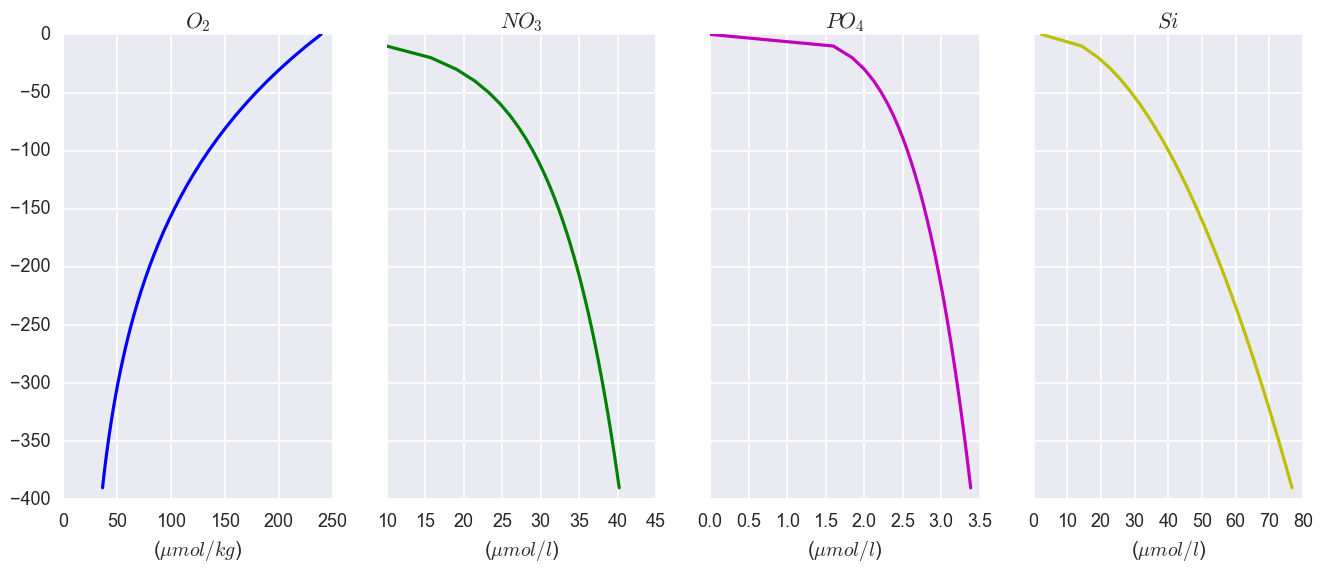

In [8]:
sns.set_context('talk')
fig, (ax2,ax3,ax4,ax5) = plt.subplots(1, 4,figsize=(16, 6), sharey=True)

ax2.plot(O2prof,-p3,'b')
ax2.set_title('$O_2$')
ax2.set_xlabel('($\mu mol/kg$)')

ax3.plot(NO3prof,-p3,'g')
ax3.set_title('$NO_3$')
ax3.set_xlabel('($\mu mol/l$)')

ax4.plot(PO4prof,-p3,'m')
ax4.set_title('$PO_4$')
ax4.set_xlabel('($\mu mol/l$)')

ax5.plot(Siprof,-p3,'y')
ax5.set_title('$Si$')
ax5.set_xlabel('($\mu mol/l$)')


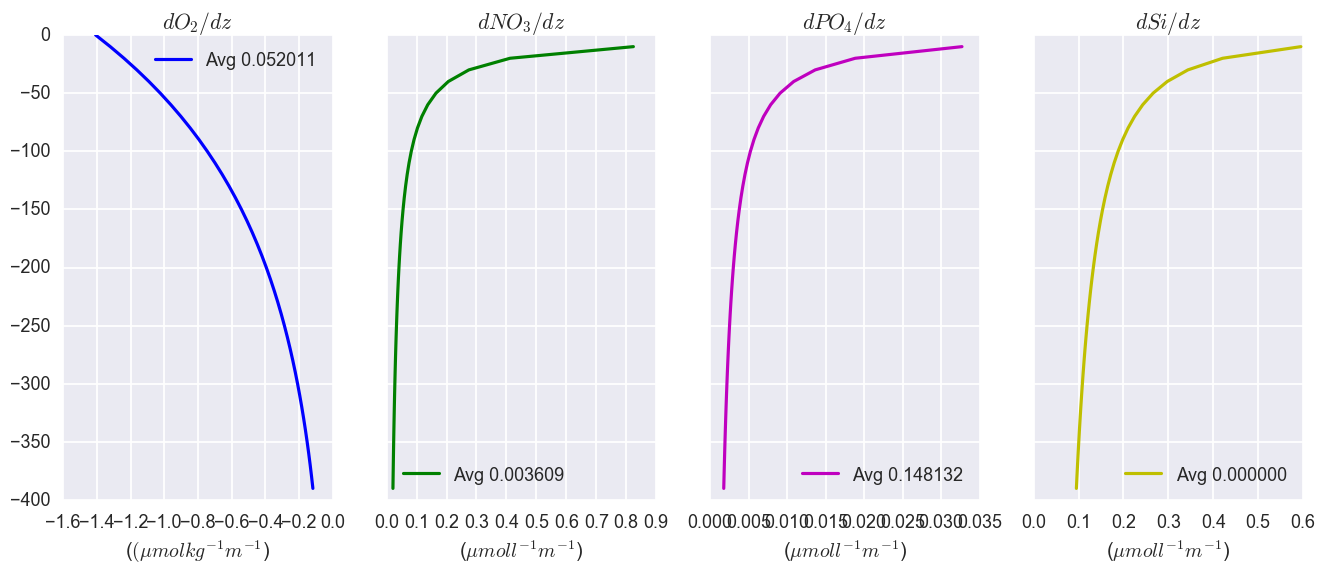

In [9]:
sns.set_context('talk')
fig, (ax2,ax3,ax4,ax5) = plt.subplots(1, 4,figsize=(16, 6), sharey=True)

ax2.plot(dvO2,-p3[:],'b',label = ('Avg %f' %dvAvg[1]))
ax2.set_title('$dO_2/dz$')
ax2.set_xlabel('($(\mu mol kg^{-1} m^{-1}$)')
ax2.legend(loc = 0)

ax3.plot(dvNO3,-p3[:],'g',label = ('Avg %f' %dvAvg[2]))
ax3.set_title('$dNO_3/dz$')
ax3.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax3.legend(loc = 0)

ax4.plot(dvPO4,-p3[:],'m',label = ('Avg %f' %dvAvg[3]))
ax4.set_title('$dPO_4/dz$')
ax4.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax4.legend(loc = 0)

ax5.plot(dvSi,-p3[:],'y',label = ('Avg %f' %dvAvg[4]))
ax5.set_title('$dSi/dz$')
ax5.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax5.legend(loc = 0)

# OJO: average dC/dz from 100 m to 250 m (below mixed layer and above upwelling depth)


In [10]:
# Methane and nitrous acid - see notebook NutrientProfilesLineC2013.ipynb in /Data

#Methane
dvAvg[4] = 0.000014 # micromol/l *1/m, original concetration is in nmol/l -sep average 2013, so that it matches year of Pathways cruise
dv2Avg[4] = -0.0000044 # micromol/l *1/m^2

dvHs[4] = 0.000019  # micromol/l *1/m  sep average 2013, so that it matches year of Pathways cruise
dv2Hs[4] = -0.000053 # micromol/l *1/m^2

# Nitrous Acid
dvAvg[5] = 0.0000408 
dv2Avg[5] = -0.0000042

dvHs[5] = 0.0000256
dv2Hs[5] = -0.000016


In [11]:
print(r'$\delta_vC$ and $\delta^2_vC$ values evaluated at Hs = 200 m and averaged over 400 m. \n')

print ("\t".join(['Tracer', '$\delta_vC$', '$\delta^2_vC$','$\delta_vC$ avg', '$\delta^2_vC$ avg']))

tr_names = ['Oxygen','Nitrate','Phosphate','Silicate','Methane','Nitrous Acid']

for ii, name in zip(range(len(tr_names)),tr_names):
    
    print ("%s\t%s" % ((name), 
         "\t".join(['%.3e\t%.3e\t%.3e\t%.3e\t' % (dvHs[ii],
                                                      dv2Hs[ii],
                                                      dvAvg[ii],
                                                      dv2Avg[ii])])))


$\delta_vC$ and $\delta^2_vC$ values evaluated at Hs = 200 m and averaged over 400 m. \n
Tracer	$\delta_vC$	$\delta^2_vC$	$\delta_vC$ avg	$\delta^2_vC$ avg
Oxygen	-3.941e-01	2.508e-03	-4.952e-01	3.151e-03	
Nitrate	4.119e-02	-2.060e-04	5.201e-02	-3.535e-04	
Phosphate	3.016e-03	-1.200e-05	3.609e-03	-1.922e-05	
Silicate	1.330e-01	-3.326e-04	1.481e-01	-4.852e-04	
Methane	1.900e-05	-5.300e-05	1.400e-05	-4.400e-06	
Nitrous Acid	2.560e-05	-1.600e-05	4.080e-05	-4.200e-06	



|Tracer|$\delta_vC$|	$\delta^2_vC$|	$\delta_vC$ avg|	$\delta^2_vC$ avg|
|:-----:|:--------:|:----------------:|:---------------:|:-------------------:|
|Oxygen|	-3.941e-01|	2.508e-03|	-4.952e-01|	3.151e-03|	
|Nitrate|	4.119e-02|	-2.060e-04|	5.201e-02|	-3.535e-04	|
|Phosphate|	3.016e-03|	-1.200e-05|	3.609e-03|	-1.922e-05	|
|Silicate|	1.330e-01|	-3.326e-04|	1.481e-01|	-4.852e-04	|
|Methane|	1.900e-05|	-5.300e-05|	1.400e-05|	-4.400e-06	|
|Nitrous Acid|	2.560e-05|	-1.600e-05|	4.080e-05|	-4.200e-06|	

In [12]:
## Horizontal profiles from Falkor, this numbercs come from NutrientProfilesFalkor.ipynb 
## in Dropbox/UBC-RESEARCH/Data/Falkor.

distBCC3 = 30.567693930847657 # distance BCC3 
distBCC5 = 15.646986778609405
distBCC7 = 4.069999999999453

dhAvg = np.zeros((4,1))

dhAvg[0] = np.mean([(67.799 - 87.799)/(distBCC3-distBCC5),( 87.799 - 95.200)/(distBCC5-distBCC7)]) # O2
dhAvg[1] = np.mean([(36.600 - 35.0)/(distBCC3-distBCC5),( 35.0 - 34.100)/(distBCC5-distBCC7)]) # NO3
dhAvg[2] = np.mean([(56.700 - 53.100)/(distBCC3-distBCC5),(53.100 - 49.799)/(distBCC5-distBCC7)]) #Si
dhAvg[3] = np.mean([(2.48 - 2.39)/(distBCC3-distBCC5),( 2.39 - 2.3100)/(distBCC5-distBCC7)]) # PO4


print(dhAvg)
print(dv2Avg)



[[-0.98985228]
 [ 0.09248698]
 [ 0.26320504]
 [ 0.00647107]]
[[  3.15127994e-03]
 [ -3.53458514e-04]
 [ -1.92245010e-05]
 [ -4.85152020e-04]
 [ -4.40000000e-06]
 [ -4.20000000e-06]]


### Calculate non-dim parameters

In [13]:
L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
W = 8300 # mid-length width

kd = 3.9E-3 # m^2s^{-1} from Gregg et al. 2011 Ascension canyon
ki = 2.0 # m^2s^{-1} from Ledwell et al. 1998
N = 5.E-3
f = 1.08E-4
Ush = 0.1
dhC = 0 # Change this later

[Pev, Peh, K] = scalingDynamics(kd,ki,N,L,f,Ush,R)

ii = 0
Tauv = np.empty(np.shape(dvAvg))
Tauh = np.empty(np.shape(dhAvg))
Gamma = np.empty(np.shape(dhAvg))

Tauv_Hs = np.empty(np.shape(dvAvg))
Tauh_Hs = np.empty(np.shape(dhAvg))
Gamma_Hs = np.empty(np.shape(dhAvg))

for ii in range(len(dhAvg)):
    
    Tauv[ii],Tauh[ii],Gamma[ii] = scalingProfiles(L,Z(f, Ush, L, R, N),dvAvg[ii],dv2Avg[ii],dhAvg[ii],dh2C = 0.0)
    Tauv_Hs[ii],Tauh_Hs[ii],Gamma_Hs[ii] = scalingProfiles(L,Z(f, Ush, L, R, N),dvHs[ii],dv2Hs[ii],dhAvg[ii],dh2C = 0.0)
  
for ii in range(len(dvAvg)):
    
    Tauv[ii] = Calc_Tauv(Z(f, Ush, L, R, N), dvAvg[ii],dv2Avg[ii])
    Tauv_Hs[ii] = Calc_Tauv(Z(f, Ush, L, R, N), dvHs[ii],dv2Hs[ii])


In [14]:
print('For all tracers: \n K=%1.3e, Pev=%1.3e, Peh=%1.3e' %(K,Pev,Peh))


For all tracers: 
 K=5.907e-03, Pev=1.227e+00, Peh=2.077e+02


For all tracers:

|K    | $Pe_v$    |    $Pe_h$ |
|----|-------|----|
|$5.907\times10^{-3}$|$1.227$|$2.077\times10^{2}$|

In [15]:
print('Gamma for O2, NO3, Silicate, PO4: \n ')
print(Gamma)

Gamma for O2, NO3, Silicate, PO4: 
 
[[  1.69789167e-03]
 [  1.90861993e-03]
 [  4.65355520e-05]
 [  7.76921384e-02]]


In [16]:
print ("\t".join(['Tracer', r'$\tau_v$', r'$\tau_v$ Avg']))

tr_names = ['Oxygen','Nitrate','Phosphate','Silicate','Methane','Nitrous Acid']

for ii, name in zip(range(len(tr_names)),tr_names):
    
    print ("%s\t%s" % ((name), 
         "\t".join(['%.3e\t%.3e\t' % (Tauv_Hs[ii],Tauv[ii])])))



Tracer	$\tau_v$	$\tau_v$ Avg
Oxygen	1.382e-01	1.382e-01	
Nitrate	1.086e-01	1.476e-01	
Phosphate	8.642e-02	1.157e-01	
Silicate	5.430e-02	7.114e-02	
Methane	6.059e+01	6.827e+00	
Nitrous Acid	1.358e+01	2.236e+00	


## Estimates

For all tracers: 
 $K=5.907\times10^{-3}$, $Pe_v=1.227$, $Pe_h=207.7$
 
 These compare well with my previous calculations.
 

|       |  Dissolved Oxygen  |   Nitrate   |    Silicate   |    Phosphate    |
|:-----:|:-----:|:-----:|:-----:|:-----:|
|$\Gamma$| $1.698\times 10^{-3}$| $1.910\times 10^{-3}$| $4.654\times 10^{-5}$| $7.769\times 10^{-2}$|
|$\tau_v$| 0.138|0.148|0.116|0.071|
|$\tau_h$| N.D. | N.D.| N.D. | N.D.|

$\tau_v$ compares well with what I had before but $\Gamma$ estimatea are too small. They were O(1) and didn't vary so much. I think it is the horizontal devivative calculation.

|Tracer|	$\tau_v$ |	$\tau_v$ Avg |
|:----:|:----:|:----:|:----:|
|Oxygen|	1.382e-01|	1.382e-01|	
|Nitrate|	1.086e-01|	1.476e-01	|
|Phosphate|	8.642e-02|	1.157e-01	|
|Silicate|	5.430e-02|	7.114e-02	|
|Methane|	6.059e+01|	6.827e+00	|
|Nitrous Acid|	1.358e+01|	2.236e+00|	
